In [457]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [458]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib as plt
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [459]:
df_train = pd.read_csv("drive/MyDrive/train.csv")
df_test = pd.read_csv("drive/MyDrive/test.csv")

In [460]:
df_train['sentimiento'] = df_train['sentimiento'].map({'positivo': 1, 'negativo': 0})

In [461]:
RUTA_GUARDADO = "XGB.csv"

In [462]:
def reemplazar_no(df):
    def reemplazo(texto):
        if isinstance(texto, str):
            return texto.replace(" película ", "").lower()
        return texto

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(reemplazo)

    return df

In [463]:
df_train = reemplazar_no(df_train)
df_test = reemplazar_no(df_test)


In [464]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


Aqui ya observamos que el dataset no contiene nulos

In [516]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.5, random_state=33)

In [517]:
x_train, y_train, x_test_, y_test_ = df_train_train["review_es"], df_train_train["sentimiento"], df_train_test["review_es"], df_train_test["sentimiento"]

In [518]:
x_test = df_test["review_es"]

In [468]:
from sklearn.model_selection import GridSearchCV

In [469]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [484]:
def imprimir_resultados(y, y_pred):

    labels = [0, 1]

    f1 = f1_score(y, y_pred, pos_label=0, labels=labels)
    precision = precision_score(y, y_pred, pos_label=0, labels=labels)
    recall = recall_score(y, y_pred, pos_label=0, labels=labels)
    accuracy = accuracy_score(y, y_pred)

    cm = confusion_matrix(y_test_, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

In [471]:
def guardar_resultado_en_csv(prediccion):

    df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": prediccion})

    df_predicciones.to_csv(RUTA_GUARDADO, header=["ID", "sentimiento"], index=False)

In [519]:
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test_)

In [473]:
def func_classif(param_distributions, cv, scoring, estimator, n_iter):
  randomcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions = param_distributions,
                                scoring=scoring,
                                cv=cv,
                                n_jobs = -1,
                                n_iter=n_iter,
                                random_state=33)

  randomcv.fit(x_train_vec, y_train)

  return randomcv

In [474]:
n_iter = 5

param_distributions = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200, 300]
    }

cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = XGBClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [475]:
best_params_xgboost = randomcv.best_params_

In [476]:
print(best_params_xgboost)

{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}


In [477]:
#{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}
# best_xgboost = XGBClassifier(learning_rate=best_params_xgboost["learning_rate"],
#                         n_estimators=best_params_xgboost["n_estimators"],
#                         max_depth=best_params_xgboost["max_depth"])

In [520]:
best_xgboost = XGBClassifier(learning_rate=0.3,
                        n_estimators=250,
                        max_depth=4)

In [521]:
best_xgboost.fit(x_train_vec, y_train)

y_pred = best_xgboost.predict(x_test_vec)

F1: 0.8499593826157597
Precision: 0.8651397387134117
Recall: 0.8353025706530417
Accuracy: 0.85224


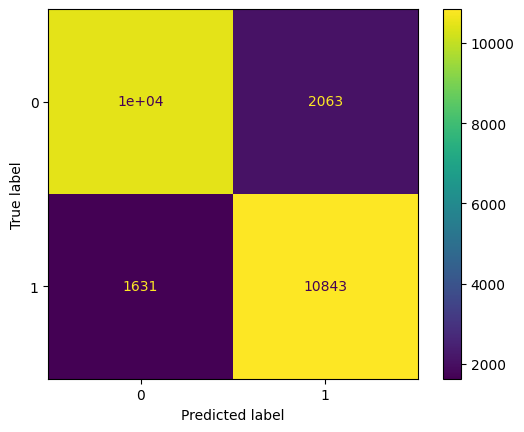

In [522]:
imprimir_resultados(y_test_, y_pred)

In [523]:
y_pred_ = best_xgboost.predict(vectorizer.transform(x_test))

In [524]:
y_pred_ = np.where(y_pred_ == 0, "negativo", "positivo")

In [525]:
guardar_resultado_en_csv(y_pred_)

In [526]:
## Testeo

In [527]:
pd.DataFrame(y_pred, columns=['Etiqueta_Predicha'])
pd.DataFrame({'review_es': x_test})
pd.DataFrame({'review_es': y_test_})


,review_es
31809,0
34702,0
14222,0
26294,0
9876,0
...,...
36849,0
11987,0
16733,1
4277,1


In [528]:
a = pd.DataFrame({'review_es': x_test_})
a.reset_index(drop=True, inplace=True)

In [529]:
b = pd.DataFrame({'sentimiento': y_test_})
b.reset_index(drop=True, inplace=True)

In [530]:
c = pd.DataFrame(y_pred, columns=['Prediccion'])
c.reset_index(drop=True, inplace=True)

In [531]:
df_resultado = pd.concat([a, b, c], axis=1)

In [532]:
df_resultado_filtro = df_resultado[df_resultado['sentimiento'] != df_resultado['Prediccion']]

In [533]:
df_resultado_filtro

,review_es,sentimiento,Prediccion
6,"por todas las apariencias, esta serie podría h...",0,1
19,"como no soy un gran fanático de steven seagal,...",0,1
32,"con todo su flash técnico, lade 1993 ""stalingr...",0,1
48,"está bien, lo diré. estame hizo reír tan fuert...",1,0
54,****************** spoiler *******************...,0,1
...,...,...,...
24979,el thriller desagradable y clichado tiene una ...,0,1
24985,"vi 'engending' anoche, y soy de dos mentes en ...",1,0
24988,lo suficientemente decente con algunas imágene...,0,1
24990,vi estacomo una chica muy joven (ahora tengo 2...,0,1
